In [1]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19, VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout
from keras.utils import to_categorical
import tensorflow as tf
import random

Using TensorFlow backend.


In [2]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [3]:
#Keras library for CIFAR dataset
from keras.datasets import cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [4]:
#Train-validation-test split
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.3)

In [5]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#Verifying the dimension after one-hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))
((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [6]:
#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range = 2, horizontal_flip = True, zoom_range = 0.1 )

val_generator = ImageDataGenerator(rotation_range = 2, horizontal_flip = True, zoom_range = 0.1)

test_generator = ImageDataGenerator(rotation_range = 2,  horizontal_flip = True, zoom_range = 0.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [7]:
#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01,  patience = 3, min_lr = 1e-5)

In [8]:
#Defining the hyperparameters
import keras
batch_size = 64
epochs = 10
learn_rate = 0.001
opt = keras.optimizers.Adam(lr = 0.001)

In [9]:
#Initialising ResNet
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (32,32,3), classes = y_train.shape[1])

C:\Users\Admin\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
#Adding layers to the ResNet
model_resnet = Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(512, activation = ('elu'), input_dim = 512))
model_resnet.add(Dense(10, activation = ('softmax')))

#Summary of ResNet Model
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 24,588,810
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
#Compiling ResNet
model_resnet.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
#Model testing and reporting
model_resnet.fit_generator(train_generator.flow(x_train, y_train, batch_size = batch_size),
                           epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,
                           validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size),
                           validation_steps = 250, callbacks = [lrr], verbose = 1)

Epoch 1/10
546/546 [==============================] - 69s 127ms/step - loss: 1.3640 - accuracy: 0.5454 - val_loss: 3.3918 - val_accuracy: 0.4063
Epoch 2/10
546/546 [==============================] - 56s 103ms/step - loss: 1.1201 - accuracy: 0.6140 - val_loss: 1.5679 - val_accuracy: 0.5713
Epoch 3/10
546/546 [==============================] - 56s 103ms/step - loss: 0.9189 - accuracy: 0.6885 - val_loss: 1.1594 - val_accuracy: 0.5634
Epoch 4/10
546/546 [==============================] - 57s 104ms/step - loss: 0.7898 - accuracy: 0.7334 - val_loss: 1.3094 - val_accuracy: 0.6388
Epoch 5/10
546/546 [==============================] - 56s 103ms/step - loss: 0.7333 - accuracy: 0.7525 - val_loss: 0.8823 - val_accuracy: 0.6826
Epoch 6/10
546/546 [==============================] - 56s 103ms/step - loss: 0.6855 - accuracy: 0.7693 - val_loss: 0.8609 - val_accuracy: 0.6815
Epoch 7/10
546/546 [==============================] - 56s 102ms/step - loss: 0.6316 - accuracy: 0.7902 - val_loss: 0.8859 - val_ac

In [13]:
#Classification report
y_pred3 = model_resnet.predict_classes(x_test)
y_true = np.argmax(y_test, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred3)

0.8024

In [14]:
#Evaluate the performance of the trained model
scores = model_resnet.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 481us/step
Test loss: 0.593665516614914
Test accuracy: 0.8023999929428101


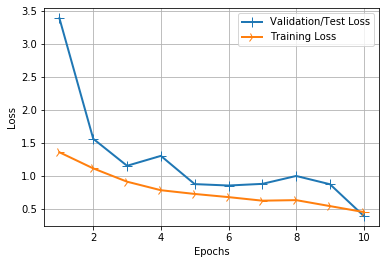

In [15]:
#Evaluating training and test error
history_dict = model_resnet.history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()